In [9]:
# During the day, HARPS-N takes repeated 5 minute-long exposures of the Sun. The result of each time of taking data is saved in a fits file.
# The structure  of each file: Each files has many "extensions"
#     - Extension 0:  Header
#     - Extension 1: Main data (influx values at each wavelength and rv
#     - Extension 2+: more meta data. Need to investigate later
# We are interested in Extension 1. This is a 2D array:
#     - Row: 70 rows in the example spans the entire spectrum from red to blue.
#             - The last row is the average of the 69 rows above it to smooth out the sensitivity of noises wrt frequency
#     - Column: 49 columns scans through a range of velocitues (from -20m/s to +20m/s)
#     - The value of each cell is the influx of light. 
# Code to do a Gausian fit to find the center of peak (so the real RV) below. 
# Once we get the center, we can shift the whole curve to Zero and normalized it (y_data = ccf[-1] / max(ccf[-1])  # Normalize data). 
# Note that, for each file, we need to do this for the last row only (to average the frequency dependent).
# It seems that, we then once again average over all files of a day to get a list of averaged, shifted, and normalized values for each day.
 
# The set of 528 such lists (for 528 days) constrcut the 'CCF_normalized_list' file in .npz file, 
# ready to generate TS traning, validation data for rv_net to diget.

# We further need to subtract values for those values of the quiet day to obtain residue values to construct 'cff_residual_list'

# We also remove the events that have planets transit across the sun (remove the real signal) to create the cut-off files? 
# (or simply remove  the first and the 2 last data points of 49?)
# The other files are meta data from fits file of each day 

# Note: 'jup_shifted_CCF_data_list' is events with Jupiter crossing extract out from days 
# --> the last row (row 69) of each day needs to be recalculated to remove Jupiter events????


In [1]:
from dace_query.sun import Sun
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np
import pandas

2025-12-12 17:30:54,783 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


In [3]:
ccf_header = fits.getheader("2015-07-29-30-31/r.HARPN.2015-07-31T09-56-34.837_CCF_A.fits")
ccf = fits.getdata("2015-07-29-30-31/r.HARPN.2015-07-31T09-56-34.837_CCF_A.fits", 1)


In [ ]:
ccf_header

In [15]:
ccf_header['HIERARCH TNG RV START']

-19.58

In [16]:
step =ccf_header['HIERARCH TNG RV STEP']
fwhm = ccf_header['HIERARCH TNG QC CCF FWHM']
cont = ccf_header['HIERARCH TNG QC CCF CONTRAST']
bis = ccf_header['HIERARCH TNG QC CCF BIS SPAN']

In [17]:
fwhm

7.06141135789394

In [ ]:
# 7.05925767515162
# We find the exact center of RV by using inverted_gaissian fit. Using this value to shift the raw data to 0

Exact Radial Velocity (Center): 0.09502 km/s
Line Width (Sigma): 2.99662 km/s


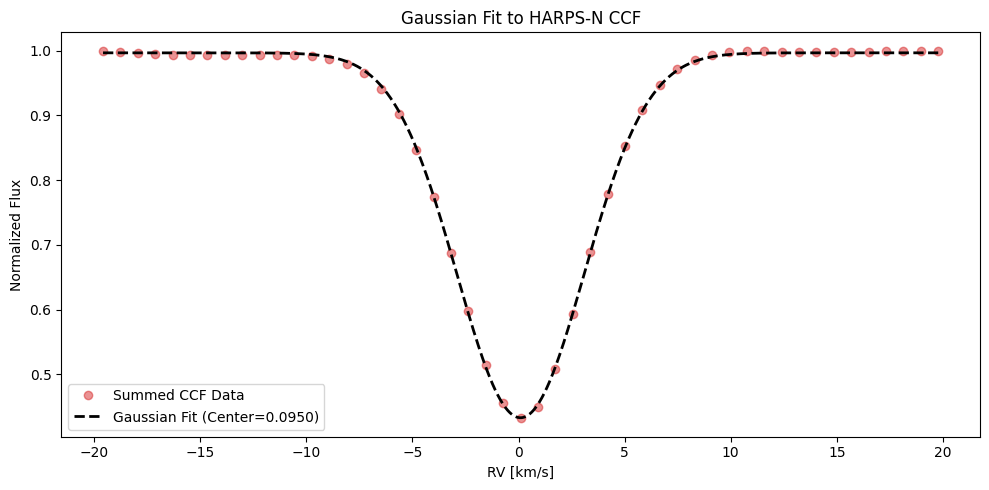

In [3]:
from scipy.optimize import curve_fit
CCF_rv = np.arange(
    ccf_header["TNG RV START"],
    ccf_header["TNG RV START"] + len(ccf[0]) * ccf_header["TNG RV STEP"],
    ccf_header["TNG RV STEP"],
)
# Prepare Data: We will fit the Summed CCF (last row)
x_data = CCF_rv
y_data = ccf[-1] / max(ccf[-1])  # Normalize data

# 1. Define the Gaussian Function (Inverted)
# y = offset - amplitude * exp( ... )
def inverted_gaussian(x, amplitude, mean, stddev, offset):
    return offset - amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# 2. Make Initial Guesses (p0)
# This helps the optimizer converge faster.
# - Center: Guess the x-value where y is minimal
mean_guess = x_data[np.argmin(y_data)]
# - Amplitude: Distance from top (1.0) to the bottom of the dip
amp_guess = 1.0 - np.min(y_data)
# - Stddev: A rough guess for width (e.g., 3 km/s)
sigma_guess = 3.0 
# - Offset: The continuum is usually normalized to 1.0
offset_guess = 1.0

p0 = [amp_guess, mean_guess, sigma_guess, offset_guess]

# 3. Perform the Fit
popt, pcov = curve_fit(inverted_gaussian, x_data, y_data, p0=p0)

# Extract the fitted parameters
fit_amp, fit_mean, fit_sigma, fit_offset = popt

print(f"Exact Radial Velocity (Center): {fit_mean:.5f} km/s")
print(f"Line Width (Sigma): {fit_sigma:.5f} km/s")

# 4. Plot the Result
plt.figure(figsize=(10, 5))

# Plot Data
plt.plot(x_data, y_data, 'o', color='C3', label='Summed CCF Data', alpha=0.5)

# Plot Fitted Curve
# We generate a smoother x-axis for the line plot
x_smooth = np.linspace(min(x_data), max(x_data), 1000)
plt.plot(x_smooth, inverted_gaussian(x_smooth, *popt), 'k--', lw=2, label=f'Gaussian Fit (Center={fit_mean:.4f})')

plt.legend()
plt.xlabel("RV [km/s]")
plt.ylabel("Normalized Flux")
plt.title("Gaussian Fit to HARPS-N CCF")
plt.tight_layout()
plt.show()

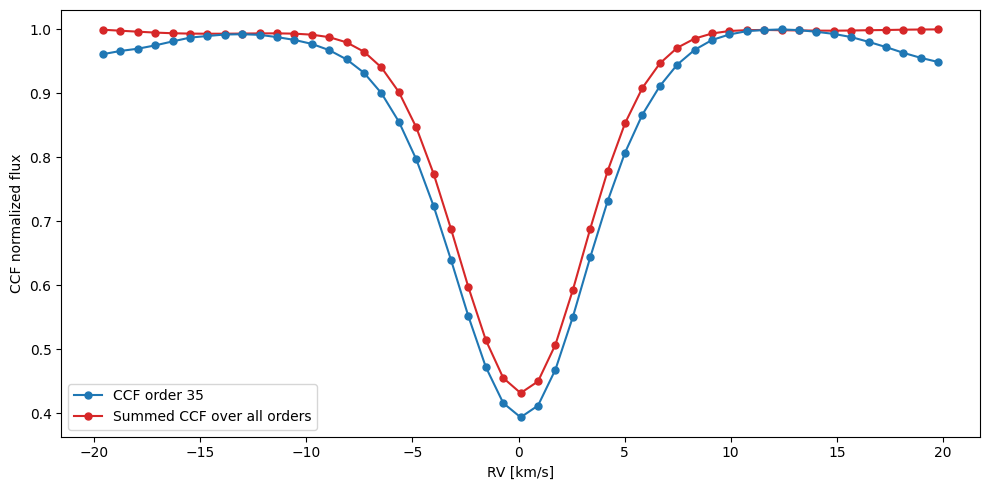

In [28]:
order = 35
plt.figure(figsize=(10, 5))
CCF_rv = np.arange(
    ccf_header["TNG RV START"],
    ccf_header["TNG RV START"] + len(ccf[0]) * ccf_header["TNG RV STEP"],
    ccf_header["TNG RV STEP"],
)
# plot the CCF of a specific order
plt.plot(
    CCF_rv,
    ccf[order] / max(ccf[order]),
    zorder=1,
    marker="o",
    ms=5,
    color="C0",
    label="CCF order %i" % (order),
)
# plot the summed ccf over all orders (last matrix element)
plt.plot(
    CCF_rv,
    ccf[-1] / max(ccf[-1]),
    zorder=0,
    marker="o",
    ms=5,
    color="C3",
    label="Summed CCF over all orders",
)
plt.legend()
plt.xlabel("RV [km/s]")
plt.ylabel("CCF normalized flux")
plt.tight_layout()

<Figure size 800x1000 with 0 Axes>

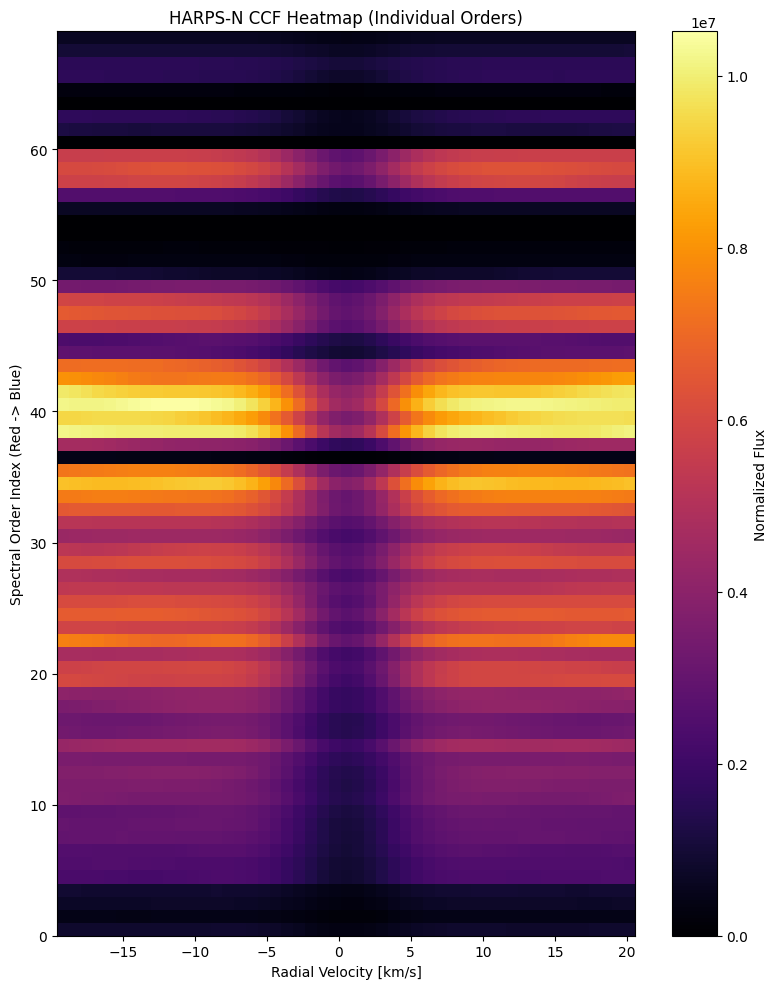

In [4]:
ccff_header = fits.getheader("r.HARPN.2015-11-01T11-37-14.939_CCF_A.fits")
ccff = fits.getdata("r.HARPN.2015-11-01T11-37-14.939_CCF_A.fits", 1)
# 3. Plot the Heatmap
plt.figure(figsize=(8, 10))  # Tall figure to see rows clearly
# 2. Reconstruct X-axis (for the extent argument)
rv_start = ccff_header["TNG RV START"]
rv_step = ccff_header["TNG RV STEP"]
rv_end = rv_start + len(ccff[0]) * rv_step
heatmap_data = ccff[:-1] 

plt.figure(figsize=(8, 10))

plt.imshow(
    heatmap_data, 
    aspect='auto', 
    origin='lower', 
    cmap='inferno',
    extent=[rv_start, rv_end, 0, 69] 
)

plt.colorbar(label='Normalized Flux')
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Spectral Order Index (Red -> Blue)')
plt.title('HARPS-N CCF Heatmap (Individual Orders)')

plt.tight_layout()
plt.show()
